# 10 - Attention Mechanisms and Transformers

## Learning Objectives

By the end of this notebook, you will:

1. **Understand attention mechanisms** - How attention allows models to focus on relevant parts of input
2. **Implement self-attention from scratch** - Scaled dot-product attention and multi-head attention
3. **Build a Transformer encoder** - Layer normalization, feedforward networks, residual connections
4. **Build a Transformer decoder** - Masked attention, cross-attention
5. **Understand positional encodings** - Why they're needed and how they work

---

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Optional, Tuple

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


---

## 1. Introduction to Attention

### 1.1 Why Attention?

Traditional seq2seq models compress entire input into a single fixed-size vector. Attention allows the model to **look back** at all input positions when generating each output.

Key insight: Not all input tokens are equally relevant for predicting each output token.

In [2]:
# Simple attention intuition

def simple_attention(query: torch.Tensor, keys: torch.Tensor, values: torch.Tensor) -> torch.Tensor:
    """
    Basic attention mechanism.
    
    Query asks: "What am I looking for?"
    Keys answer: "What do I contain?"
    Values contain: "What information do I have?"
    
    Args:
        query: What we're searching for (d_k,)
        keys: What each position contains (seq_len, d_k)
        values: Information at each position (seq_len, d_v)
    
    Returns:
        Weighted sum of values based on query-key similarity
    """
    # Compute similarity scores
    scores = torch.matmul(keys, query)  # (seq_len,)
    
    # Convert to probabilities
    weights = F.softmax(scores, dim=0)  # (seq_len,)
    
    # Weighted sum of values
    output = torch.matmul(weights, values)  # (d_v,)
    
    return output, weights


# Example: finding relevant information
d_k, d_v, seq_len = 4, 8, 5

query = torch.randn(d_k)
keys = torch.randn(seq_len, d_k)
values = torch.randn(seq_len, d_v)

output, weights = simple_attention(query, keys, values)
print(f"Query shape: {query.shape}")
print(f"Keys shape: {keys.shape}")
print(f"Values shape: {values.shape}")
print(f"Attention weights: {weights}")
print(f"Weights sum to 1: {weights.sum():.4f}")
print(f"Output shape: {output.shape}")

Query shape: torch.Size([4])
Keys shape: torch.Size([5, 4])
Values shape: torch.Size([5, 8])
Attention weights: tensor([0.3552, 0.1045, 0.2147, 0.1962, 0.1295])
Weights sum to 1: 1.0000
Output shape: torch.Size([8])


### 1.2 Scaled Dot-Product Attention

The Transformer uses **scaled** dot-product attention:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The scaling by $\sqrt{d_k}$ prevents the dot products from getting too large (which would make softmax saturate).

In [3]:
def scaled_dot_product_attention(
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    mask: Optional[torch.Tensor] = None,
    dropout: float = 0.0
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Scaled Dot-Product Attention.
    
    Args:
        query: (batch, num_heads, seq_len_q, d_k)
        key: (batch, num_heads, seq_len_k, d_k)
        value: (batch, num_heads, seq_len_k, d_v)
        mask: Optional mask (batch, 1, 1, seq_len_k) or (batch, 1, seq_len_q, seq_len_k)
        dropout: Dropout probability
    
    Returns:
        output: (batch, num_heads, seq_len_q, d_v)
        attention_weights: (batch, num_heads, seq_len_q, seq_len_k)
    """
    d_k = query.size(-1)
    
    # Compute attention scores
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # scores: (batch, num_heads, seq_len_q, seq_len_k)
    
    # Apply mask (if provided)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # Softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Apply dropout
    if dropout > 0:
        attention_weights = F.dropout(attention_weights, p=dropout)
    
    # Weighted sum of values
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights


# Test
batch, num_heads, seq_len, d_k = 2, 4, 10, 64
d_v = d_k

Q = torch.randn(batch, num_heads, seq_len, d_k)
K = torch.randn(batch, num_heads, seq_len, d_k)
V = torch.randn(batch, num_heads, seq_len, d_v)

output, attn_weights = scaled_dot_product_attention(Q, K, V)
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

Output shape: torch.Size([2, 4, 10, 64])
Attention weights shape: torch.Size([2, 4, 10, 10])


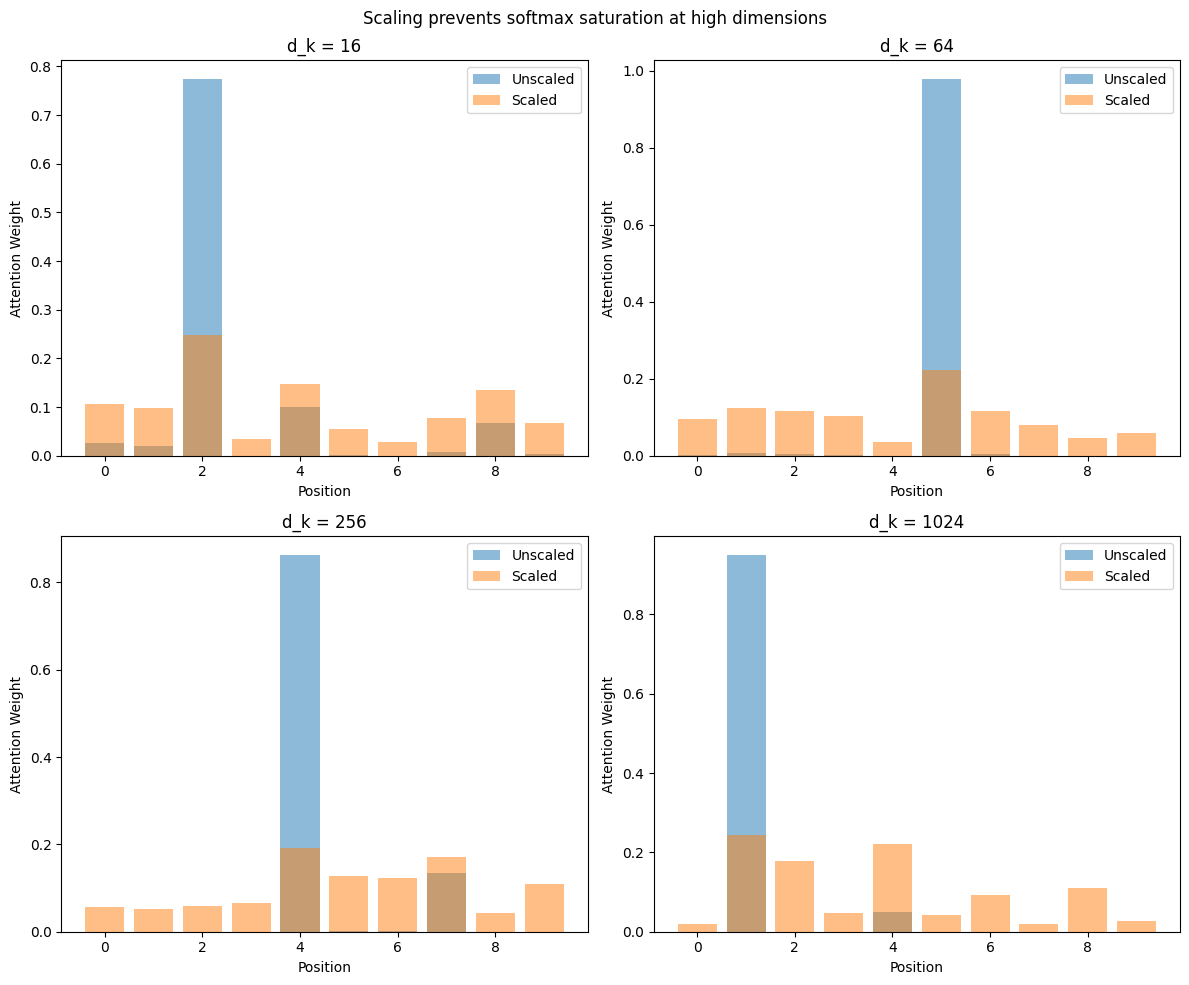

In [4]:
# Why scaling matters

def show_scaling_effect():
    """Demonstrate why we scale by sqrt(d_k)"""
    d_k_values = [16, 64, 256, 1024]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for ax, d_k in zip(axes, d_k_values):
        # Random Q, K
        Q = torch.randn(1, 1, 10, d_k)
        K = torch.randn(1, 1, 10, d_k)
        
        # Unscaled scores
        scores_unscaled = torch.matmul(Q, K.transpose(-2, -1))
        
        # Scaled scores
        scores_scaled = scores_unscaled / math.sqrt(d_k)
        
        # Softmax
        attn_unscaled = F.softmax(scores_unscaled, dim=-1)
        attn_scaled = F.softmax(scores_scaled, dim=-1)
        
        # Visualize
        ax.bar(range(10), attn_unscaled[0, 0, 0].numpy(), alpha=0.5, label='Unscaled')
        ax.bar(range(10), attn_scaled[0, 0, 0].numpy(), alpha=0.5, label='Scaled')
        ax.set_xlabel('Position')
        ax.set_ylabel('Attention Weight')
        ax.set_title(f'd_k = {d_k}')
        ax.legend()
    
    plt.suptitle('Scaling prevents softmax saturation at high dimensions')
    plt.tight_layout()
    plt.show()

show_scaling_effect()

---

## 2. Multi-Head Attention

Instead of a single attention function, we project Q, K, V into multiple subspaces ("heads") and attend in parallel. This allows the model to attend to different aspects of the input simultaneously.

In [5]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention from "Attention Is All You Need".
    
    MultiHead(Q, K, V) = Concat(head_1, ..., head_h) @ W_o
    where head_i = Attention(Q @ W_q^i, K @ W_k^i, V @ W_v^i)
    """
    
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            query: (batch, seq_len_q, d_model)
            key: (batch, seq_len_k, d_model)
            value: (batch, seq_len_k, d_model)
            mask: Optional attention mask
        
        Returns:
            output: (batch, seq_len_q, d_model)
            attention_weights: (batch, num_heads, seq_len_q, seq_len_k)
        """
        batch_size = query.size(0)
        
        # Linear projections
        Q = self.W_q(query)  # (batch, seq_len_q, d_model)
        K = self.W_k(key)    # (batch, seq_len_k, d_model)
        V = self.W_v(value)  # (batch, seq_len_k, d_model)
        
        # Reshape to (batch, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )
        
        # Final linear projection
        output = self.W_o(attn_output)
        output = self.dropout(output)
        
        return output, attn_weights


# Test
mha = MultiHeadAttention(d_model=256, num_heads=8)
x = torch.randn(4, 20, 256)  # (batch, seq_len, d_model)

# Self-attention: Q=K=V=x
output, attn = mha(x, x, x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention shape: {attn.shape}")

Input shape: torch.Size([4, 20, 256])
Output shape: torch.Size([4, 20, 256])
Attention shape: torch.Size([4, 8, 20, 20])


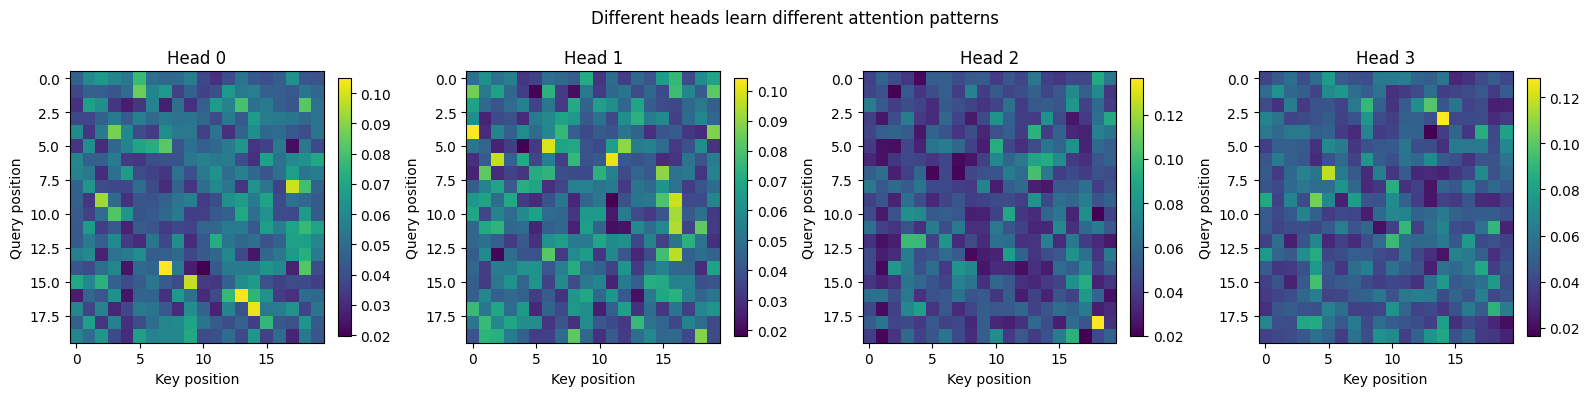

In [6]:
# Visualize attention patterns

def visualize_attention_heads(attn_weights: torch.Tensor, num_heads_to_show: int = 4):
    """Visualize attention patterns from different heads"""
    # attn_weights: (batch, num_heads, seq_len_q, seq_len_k)
    attn = attn_weights[0].detach().cpu().numpy()  # First batch item
    
    fig, axes = plt.subplots(1, num_heads_to_show, figsize=(4*num_heads_to_show, 4))
    
    for i, ax in enumerate(axes):
        im = ax.imshow(attn[i], cmap='viridis', aspect='auto')
        ax.set_xlabel('Key position')
        ax.set_ylabel('Query position')
        ax.set_title(f'Head {i}')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle('Different heads learn different attention patterns')
    plt.tight_layout()
    plt.show()

visualize_attention_heads(attn)

---

## 3. Positional Encoding

Transformers have no inherent notion of position (unlike RNNs). We add **positional encodings** to give the model position information.

The original Transformer uses sinusoidal positional encodings:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

In [7]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal Positional Encoding from "Attention Is All You Need".
    
    Properties:
    - Fixed (not learned)
    - Can handle any sequence length
    - PE(pos+k) can be represented as a linear function of PE(pos)
    """
    
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Compute the positional encodings in log space for numerical stability
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        
        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        
        # Register as buffer (not a parameter, but part of state)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
        
        Returns:
            x + positional encoding
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# Test
pe = PositionalEncoding(d_model=256)
x = torch.randn(4, 100, 256)
output = pe(x)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([4, 100, 256])


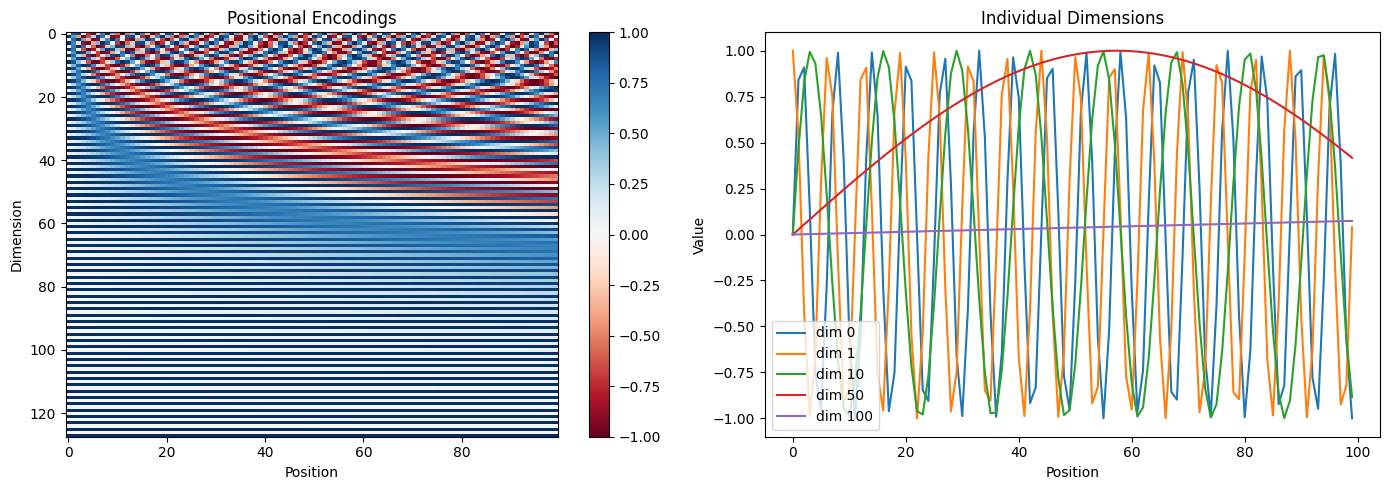

In [8]:
# Visualize positional encodings

def visualize_positional_encodings(d_model: int = 128, max_len: int = 100):
    """Visualize the sinusoidal positional encodings"""
    pe = PositionalEncoding(d_model, max_len, dropout=0)
    
    # Get the encodings
    encodings = pe.pe[0, :max_len, :].numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Heatmap of all encodings
    im = axes[0].imshow(encodings.T, aspect='auto', cmap='RdBu')
    axes[0].set_xlabel('Position')
    axes[0].set_ylabel('Dimension')
    axes[0].set_title('Positional Encodings')
    plt.colorbar(im, ax=axes[0])
    
    # Individual dimensions
    for dim in [0, 1, 10, 50, 100]:
        if dim < d_model:
            axes[1].plot(encodings[:, dim], label=f'dim {dim}')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Value')
    axes[1].set_title('Individual Dimensions')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

visualize_positional_encodings()

In [9]:
# Alternative: Learned positional embeddings

class LearnedPositionalEmbedding(nn.Module):
    """Learned positional embeddings (used in BERT, GPT)"""
    
    def __init__(self, d_model: int, max_len: int = 512, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device)
        pos_embedding = self.embedding(positions)  # (seq_len, d_model)
        return self.dropout(x + pos_embedding)


# Comparison
print("Sinusoidal PE: Fixed, can extrapolate to longer sequences")
print("Learned PE: More flexible, but limited to training length")

Sinusoidal PE: Fixed, can extrapolate to longer sequences
Learned PE: More flexible, but limited to training length


---

## 4. Transformer Encoder

The encoder consists of stacked encoder layers, each containing:
1. Multi-head self-attention
2. Position-wise feedforward network
3. Residual connections and layer normalization

In [10]:
class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network.
    
    FFN(x) = ReLU(x @ W_1 + b_1) @ W_2 + b_2
    
    Typically d_ff = 4 * d_model
    """
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


class EncoderLayer(nn.Module):
    """
    Single Transformer Encoder Layer.
    
    Structure:
        x -> LayerNorm -> MultiHeadAttention -> + -> LayerNorm -> FFN -> +
             |__________________________________|    |_________________|
    """
    
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Self-attention with residual connection
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x


class TransformerEncoder(nn.Module):
    """
    Stack of Transformer Encoder Layers.
    """
    
    def __init__(self, num_layers: int, d_model: int, num_heads: int, 
                 d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


# Test
encoder = TransformerEncoder(
    num_layers=6,
    d_model=256,
    num_heads=8,
    d_ff=1024,
    dropout=0.1
)

x = torch.randn(4, 50, 256)
output = encoder(x)
print(f"Encoder input: {x.shape}")
print(f"Encoder output: {output.shape}")
print(f"Parameters: {sum(p.numel() for p in encoder.parameters()):,}")

Encoder input: torch.Size([4, 50, 256])
Encoder output: torch.Size([4, 50, 256])
Parameters: 4,739,072


---

## 5. Transformer Decoder

The decoder is similar to the encoder but has:
1. **Masked self-attention**: Prevents attending to future tokens
2. **Cross-attention**: Attends to encoder output

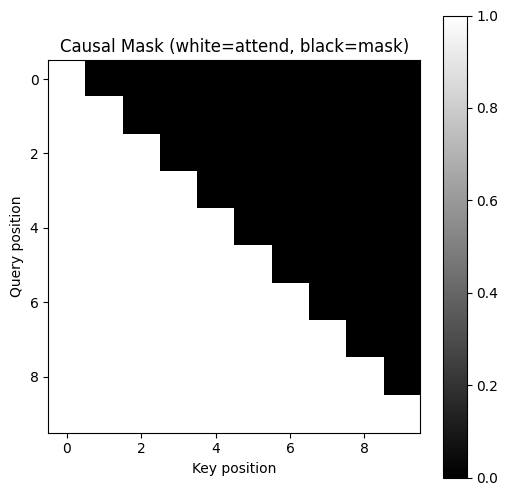

In [11]:
def create_causal_mask(seq_len: int) -> torch.Tensor:
    """
    Create a causal (look-ahead) mask for decoder self-attention.
    
    Prevents position i from attending to positions > i.
    
    Returns:
        mask: (1, 1, seq_len, seq_len) where 1 = attend, 0 = mask
    """
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    mask = mask == 0  # Invert: True where we can attend
    return mask.unsqueeze(0).unsqueeze(0)


# Visualize causal mask
mask = create_causal_mask(10)
plt.figure(figsize=(6, 6))
plt.imshow(mask[0, 0].float(), cmap='gray')
plt.xlabel('Key position')
plt.ylabel('Query position')
plt.title('Causal Mask (white=attend, black=mask)')
plt.colorbar()
plt.show()

In [12]:
class DecoderLayer(nn.Module):
    """
    Single Transformer Decoder Layer.
    
    Structure:
        x -> LayerNorm -> MaskedSelfAttn -> + -> LayerNorm -> CrossAttn -> + -> LayerNorm -> FFN -> +
    """
    
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        self_attn_mask: Optional[torch.Tensor] = None,
        cross_attn_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        # Masked self-attention
        attn_output, _ = self.self_attn(x, x, x, self_attn_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Cross-attention (attend to encoder output)
        attn_output, _ = self.cross_attn(x, encoder_output, encoder_output, cross_attn_mask)
        x = self.norm2(x + self.dropout(attn_output))
        
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x


class TransformerDecoder(nn.Module):
    """
    Stack of Transformer Decoder Layers.
    """
    
    def __init__(self, num_layers: int, d_model: int, num_heads: int,
                 d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
    
    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        self_attn_mask: Optional[torch.Tensor] = None,
        cross_attn_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, encoder_output, self_attn_mask, cross_attn_mask)
        return self.norm(x)


# Test decoder
decoder = TransformerDecoder(
    num_layers=6,
    d_model=256,
    num_heads=8,
    d_ff=1024
)

tgt = torch.randn(4, 30, 256)  # Target sequence
memory = torch.randn(4, 50, 256)  # Encoder output
causal_mask = create_causal_mask(30)

output = decoder(tgt, memory, causal_mask)
print(f"Target shape: {tgt.shape}")
print(f"Encoder output shape: {memory.shape}")
print(f"Decoder output shape: {output.shape}")

Target shape: torch.Size([4, 30, 256])
Encoder output shape: torch.Size([4, 50, 256])
Decoder output shape: torch.Size([4, 30, 256])


---

## 6. Complete Transformer Model

In [13]:
class Transformer(nn.Module):
    """
    Complete Transformer model for sequence-to-sequence tasks.
    """
    
    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        d_model: int = 512,
        num_heads: int = 8,
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        d_ff: int = 2048,
        max_len: int = 5000,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len, dropout)
        
        # Encoder and decoder
        self.encoder = TransformerEncoder(
            num_encoder_layers, d_model, num_heads, d_ff, dropout
        )
        self.decoder = TransformerDecoder(
            num_decoder_layers, d_model, num_heads, d_ff, dropout
        )
        
        # Output projection
        self.output_proj = nn.Linear(d_model, tgt_vocab_size)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights with Xavier uniform"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def encode(self, src: torch.Tensor, src_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Encode source sequence"""
        src_emb = self.src_embedding(src) * math.sqrt(self.d_model)
        src_emb = self.positional_encoding(src_emb)
        return self.encoder(src_emb, src_mask)
    
    def decode(
        self,
        tgt: torch.Tensor,
        memory: torch.Tensor,
        tgt_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """Decode target sequence"""
        tgt_emb = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.positional_encoding(tgt_emb)
        return self.decoder(tgt_emb, memory, tgt_mask)
    
    def forward(
        self,
        src: torch.Tensor,
        tgt: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None,
        tgt_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            src: Source tokens (batch, src_len)
            tgt: Target tokens (batch, tgt_len)
            src_mask: Source padding mask
            tgt_mask: Target causal + padding mask
        
        Returns:
            Logits over target vocabulary (batch, tgt_len, tgt_vocab_size)
        """
        # Encode
        memory = self.encode(src, src_mask)
        
        # Decode
        decoder_output = self.decode(tgt, memory, tgt_mask)
        
        # Project to vocabulary
        return self.output_proj(decoder_output)


# Test complete Transformer
transformer = Transformer(
    src_vocab_size=10000,
    tgt_vocab_size=10000,
    d_model=256,
    num_heads=8,
    num_encoder_layers=3,
    num_decoder_layers=3,
    d_ff=1024
)

src = torch.randint(0, 10000, (4, 30))
tgt = torch.randint(0, 10000, (4, 20))
tgt_mask = create_causal_mask(20)

output = transformer(src, tgt, tgt_mask=tgt_mask)
print(f"Source shape: {src.shape}")
print(f"Target shape: {tgt.shape}")
print(f"Output shape: {output.shape}")
print(f"Total parameters: {sum(p.numel() for p in transformer.parameters()):,}")

Source shape: torch.Size([4, 30])
Target shape: torch.Size([4, 20])
Output shape: torch.Size([4, 20, 10000])
Total parameters: 13,220,624


---

## 7. PyTorch's nn.Transformer

In [14]:
# PyTorch provides a built-in Transformer

pytorch_transformer = nn.Transformer(
    d_model=256,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=1024,
    dropout=0.1,
    batch_first=True  # PyTorch 1.9+
)

# Note: PyTorch Transformer expects already embedded inputs
src = torch.randn(4, 30, 256)  # (batch, src_len, d_model)
tgt = torch.randn(4, 20, 256)  # (batch, tgt_len, d_model)

# Generate masks
tgt_mask = nn.Transformer.generate_square_subsequent_mask(20)

output = pytorch_transformer(src, tgt, tgt_mask=tgt_mask)
print(f"PyTorch Transformer output: {output.shape}")

PyTorch Transformer output: torch.Size([4, 20, 256])


---

## 8. Decoder-Only Transformer (GPT-style)

In [15]:
class GPTBlock(nn.Module):
    """Single GPT-style decoder block (no cross-attention)"""
    
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        self.attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Pre-norm architecture (GPT-2 style)
        attn_output, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x), mask)
        x = x + attn_output
        
        ff_output = self.feed_forward(self.norm2(x))
        x = x + ff_output
        
        return x


class GPT(nn.Module):
    """
    GPT-style decoder-only Transformer.
    
    Used for language modeling and text generation.
    """
    
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 768,
        num_heads: int = 12,
        num_layers: int = 12,
        d_ff: int = 3072,
        max_len: int = 1024,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        
        # Token and position embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            GPTBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size, bias=False)
        
        # Weight tying
        self.output_proj.weight = self.token_embedding.weight
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Token indices (batch, seq_len)
        
        Returns:
            Logits (batch, seq_len, vocab_size)
        """
        batch_size, seq_len = x.shape
        device = x.device
        
        # Embeddings
        positions = torch.arange(seq_len, device=device)
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(positions)
        
        x = self.dropout(tok_emb + pos_emb)
        
        # Causal mask
        mask = create_causal_mask(seq_len).to(device)
        
        # Transformer blocks
        for block in self.blocks:
            x = block(x, mask)
        
        x = self.norm(x)
        logits = self.output_proj(x)
        
        return logits


# Test GPT
gpt = GPT(
    vocab_size=50257,  # GPT-2 vocab size
    d_model=256,
    num_heads=8,
    num_layers=6,
    d_ff=1024,
    max_len=512
)

x = torch.randint(0, 50257, (4, 100))
logits = gpt(x)
print(f"GPT input: {x.shape}")
print(f"GPT output: {logits.shape}")
print(f"Parameters: {sum(p.numel() for p in gpt.parameters()):,}")

GPT input: torch.Size([4, 100])
GPT output: torch.Size([4, 100, 50257])
Parameters: 17,735,936


In [16]:
# Text generation with GPT

@torch.no_grad()
def generate(model, start_tokens: torch.Tensor, max_new_tokens: int = 50, 
             temperature: float = 1.0, top_k: int = 50) -> torch.Tensor:
    """
    Generate text autoregressively.
    """
    model.eval()
    device = next(model.parameters()).device
    x = start_tokens.to(device)
    
    for _ in range(max_new_tokens):
        # Get logits for last position
        logits = model(x)[:, -1, :] / temperature
        
        # Top-k sampling
        if top_k > 0:
            values, _ = torch.topk(logits, top_k)
            logits[logits < values[:, -1:]] = float('-inf')
        
        # Sample
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, 1)
        
        x = torch.cat([x, next_token], dim=1)
    
    return x


# Test generation
start = torch.randint(0, 50257, (1, 5))
generated = generate(gpt, start, max_new_tokens=20)
print(f"Generated sequence: {generated.shape}")

Generated sequence: torch.Size([1, 25])


---

## Exercises

### Exercise 1: Implement Relative Positional Encoding

Instead of absolute positions, encode relative distances between tokens.

In [17]:
# Exercise 1: Relative positional encoding

class RelativePositionalAttention(nn.Module):
    """
    Self-attention with relative positional encodings.
    
    Instead of PE(i) + PE(j), we learn embeddings for relative positions (i - j).
    
    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        max_relative_position: Maximum relative position to consider
    """
    
    def __init__(self, d_model: int, num_heads: int, max_relative_position: int = 32):
        super().__init__()
        # YOUR CODE HERE
        # Hint: Create learnable embeddings for relative positions from
        # -max_relative_position to +max_relative_position
        pass
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE
        # Hint: Compute attention scores including relative position bias
        pass

### Exercise 2: Implement Multi-Query Attention

Multi-Query Attention (MQA) uses shared K and V across heads for efficiency.

In [18]:
# Exercise 2: Multi-Query Attention

class MultiQueryAttention(nn.Module):
    """
    Multi-Query Attention: each head has its own Q, but K and V are shared.
    
    Much faster during inference (smaller KV cache).
    """
    
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        # YOUR CODE HERE
        # Hint: W_q should project to d_model (for all heads)
        # W_k and W_v should project to d_k (shared across heads)
        pass
    
    def forward(self, query, key, value, mask=None):
        # YOUR CODE HERE
        pass

### Exercise 3: Visualize Attention Patterns

Create a function to visualize attention patterns for a trained model.

In [19]:
# Exercise 3: Attention visualization

def visualize_attention_patterns(
    model,
    tokens: torch.Tensor,
    layer_idx: int = 0,
    head_idx: Optional[int] = None
):
    """
    Visualize attention patterns from a transformer model.
    
    Args:
        model: Transformer model
        tokens: Input token indices (1, seq_len)
        layer_idx: Which layer to visualize
        head_idx: Which head (None = average across heads)
    
    Should:
    1. Hook into the model to capture attention weights
    2. Run forward pass
    3. Visualize the attention matrix
    """
    # YOUR CODE HERE
    pass

---

## Solutions

In [20]:
# Solution 1: Relative Positional Encoding

class RelativePositionalAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, max_relative_position: int = 32):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.max_relative_position = max_relative_position
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        # Relative position embeddings
        # Range: [-max_relative_position, max_relative_position]
        num_positions = 2 * max_relative_position + 1
        self.relative_position_embedding = nn.Embedding(num_positions, self.d_k)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        
        # Project Q, K, V
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Compute relative positions
        positions = torch.arange(seq_len, device=x.device)
        relative_positions = positions.unsqueeze(0) - positions.unsqueeze(1)
        relative_positions = relative_positions.clamp(-self.max_relative_position, self.max_relative_position)
        relative_positions = relative_positions + self.max_relative_position  # Shift to [0, 2*max]
        
        # Get relative position embeddings
        rel_pos_emb = self.relative_position_embedding(relative_positions)  # (seq, seq, d_k)
        
        # Content-based attention
        content_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Position-based attention
        # Q: (batch, heads, seq, d_k) @ rel_pos_emb: (seq, seq, d_k).T
        position_scores = torch.einsum('bhqd,qkd->bhqk', Q, rel_pos_emb) / math.sqrt(self.d_k)
        
        # Combine
        scores = content_scores + position_scores
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        
        # Reshape and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.W_o(attn_output)


# Test
rel_attn = RelativePositionalAttention(256, 8, max_relative_position=16)
x = torch.randn(4, 50, 256)
output = rel_attn(x)
print(f"Relative attention output: {output.shape}")

Relative attention output: torch.Size([4, 50, 256])


In [21]:
# Solution 2: Multi-Query Attention

class MultiQueryAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Each head has its own Q projection
        self.W_q = nn.Linear(d_model, d_model)
        
        # K and V are shared (single head dimension)
        self.W_k = nn.Linear(d_model, self.d_k)
        self.W_v = nn.Linear(d_model, self.d_k)
        
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        batch_size, seq_len_q, _ = query.shape
        seq_len_k = key.shape[1]
        
        # Project Q (per head), K, V (shared)
        Q = self.W_q(query).view(batch_size, seq_len_q, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key)  # (batch, seq_k, d_k)
        V = self.W_v(value)  # (batch, seq_k, d_k)
        
        # Expand K, V for all heads
        K = K.unsqueeze(1)  # (batch, 1, seq_k, d_k)
        V = V.unsqueeze(1)  # (batch, 1, seq_k, d_k)
        
        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to V (broadcast across heads)
        attn_output = torch.matmul(attn_weights, V)
        
        # Reshape
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len_q, self.d_model)
        
        return self.W_o(attn_output), attn_weights


# Compare parameter counts
mha = MultiHeadAttention(256, 8)
mqa = MultiQueryAttention(256, 8)

print(f"Multi-Head Attention params: {sum(p.numel() for p in mha.parameters()):,}")
print(f"Multi-Query Attention params: {sum(p.numel() for p in mqa.parameters()):,}")

Multi-Head Attention params: 263,168
Multi-Query Attention params: 148,032


In [22]:
# Solution 3: Attention visualization

def visualize_attention_patterns(
    model,
    tokens: torch.Tensor,
    token_labels: Optional[List[str]] = None,
    layer_idx: int = 0,
    head_idx: Optional[int] = None
):
    """Visualize attention patterns"""
    model.eval()
    device = next(model.parameters()).device
    tokens = tokens.to(device)
    
    # Store attention weights
    attention_weights = []
    
    def hook_fn(module, input, output):
        # output is (attn_output, attn_weights)
        if isinstance(output, tuple) and len(output) == 2:
            attention_weights.append(output[1].detach().cpu())
    
    # Register hooks
    hooks = []
    for i, block in enumerate(model.blocks):
        if i == layer_idx:
            hooks.append(block.attn.register_forward_hook(hook_fn))
    
    # Forward pass
    with torch.no_grad():
        _ = model(tokens)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    if not attention_weights:
        print("No attention weights captured")
        return
    
    attn = attention_weights[0][0]  # First batch item
    seq_len = attn.shape[-1]
    
    if head_idx is not None:
        # Single head
        attn_to_show = attn[head_idx].numpy()
        title = f'Layer {layer_idx}, Head {head_idx}'
    else:
        # Average across heads
        attn_to_show = attn.mean(dim=0).numpy()
        title = f'Layer {layer_idx}, Average across heads'
    
    plt.figure(figsize=(10, 8))
    plt.imshow(attn_to_show, cmap='viridis')
    plt.colorbar(label='Attention weight')
    
    if token_labels:
        plt.xticks(range(len(token_labels)), token_labels, rotation=45, ha='right')
        plt.yticks(range(len(token_labels)), token_labels)
    
    plt.xlabel('Key position')
    plt.ylabel('Query position')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Test with our GPT model
# Note: Need to modify GPT to return attention weights for this to work properly
print("Attention visualization function defined!")

NameError: name 'List' is not defined

---

## Summary

### Key Takeaways

1. **Attention Mechanism**:
   - Query, Key, Value paradigm
   - Scaled dot-product prevents softmax saturation
   - Allows attending to all positions in parallel

2. **Multi-Head Attention**:
   - Multiple attention patterns learned simultaneously
   - Each head can focus on different aspects
   - Typical: 8-16 heads

3. **Positional Encoding**:
   - Transformers have no built-in position sense
   - Sinusoidal: fixed, can extrapolate
   - Learned: more flexible, fixed max length

4. **Transformer Architecture**:
   - Encoder: self-attention + FFN
   - Decoder: masked self-attention + cross-attention + FFN
   - Residual connections and layer norm throughout

5. **Variants**:
   - Encoder-only (BERT): bidirectional, for understanding
   - Decoder-only (GPT): causal, for generation
   - Encoder-decoder: for seq2seq tasks

### Complexity

| Operation | Time Complexity | Space Complexity |
|-----------|-----------------|------------------|
| Self-attention | O(n² · d) | O(n²) |
| FFN | O(n · d · d_ff) | O(n · d_ff) |

Where n = sequence length, d = model dimension